# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import cv2
import numpy as np
import scipy
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt
import utils
import os

In [2]:
def plot_no_frame(img, cmap=None, title=None):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    
    if cmap is not None:
        ax.imshow(img, cmap=cmap)
    else:
        ax.imshow(img)
        
    ax.set_axis_off()
    fig.add_axes(ax)

    dpi = fig.get_dpi()
    fig.set_size_inches(img.shape[1]/float(dpi), img.shape[0]/float(dpi))
    return fig

### Part I: Randomly Sampled Texture (10 pts)

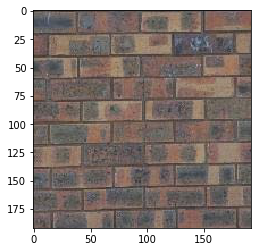

In [3]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.imshow(sample_img)

In [4]:
def sample_single_patch(sample, patch_size):
    h, w, _ = sample.shape
    ws = np.random.randint(0, w-patch_size+1)
    hs = np.random.randint(0, h-patch_size+1)
    return sample[hs:hs+patch_size, ws:ws+patch_size, :]

In [5]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    h, w, c = sample.shape 
    
    n_patch = int(out_size/patch_size)
    out = np.zeros((out_size, out_size, c))
    for h_i in range(n_patch):
        for w_i in range(n_patch):
            patch = sample_single_patch(sample, patch_size)
            
            h_start = patch_size * h_i; h_end = patch_size * (h_i+1)
            w_start = patch_size * w_i; w_end = patch_size * (w_i+1)
            out[h_start:h_end, w_start:w_end, :] = patch
            
    return out.astype(np.uint8)

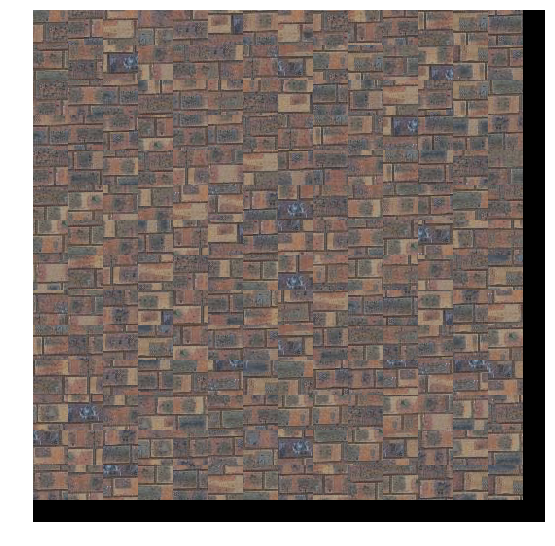

In [6]:
out_size = 512  # feel free to change to debug
patch_size = 35 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    fig = plot_no_frame(res)
    fig.savefig("results/random.png")

### Part II: Overlapping Patches (30 pts)

In [7]:
def ssd_patch(sample, mask, template, overlap,
              cor_sample=None, cor_template=None, alpha=0.5):

    ssd = np.zeros_like(sample)
    if mask is not None:
        mask = mask.astype(np.float32)
    if template is not None:
        ssd = ((mask * template) ** 2).sum() \
            - 2 * cv2.filter2D(sample, ddepth=-1, kernel=mask * template) \
            + cv2.filter2D(sample ** 2, ddepth=-1, kernel=mask)

    if cor_sample is not None:
        cor_template = cor_template.astype(np.float32)
        cor_ssd = (cor_template ** 2).sum() \
                - 2 * cv2.filter2D(cor_sample, ddepth=-1, kernel=cor_template) \
                + cv2.filter2D(cor_sample ** 2, ddepth=-1, kernel=np.ones_like(cor_template))

        ssd = ssd * alpha + (1-alpha) * cor_ssd

    return ssd

In [8]:
def choose_sample(ssd, patch_shape, sample, k=5):
    h, w = patch_shape
    sh, sw = ssd.shape

    h_start = int(h/2); h_end = sh - int(h/2) + (h+1) % 2
    w_start = int(w/2); w_end = sw - int(w/2) + (w+1) % 2; w_len = w_end - w_start

    indices = np.argsort(ssd[h_start:h_end, w_start:w_end].flatten())

    ind = np.random.choice(indices[:k], 1)[0]
    h_i = int(ind / w_len); w_i = ind % w_len

    hs = h_start + h_i - int(h/2)
    he = h_start + h_i + int(h/2) + h % 2
    ws = w_start + w_i - int(w/2)
    we = w_start + w_i + int(w/2) + w % 2

    return sample[hs:he, ws:we, :], (hs, he), (ws, we)

In [9]:
def generate_mask(h_i, w_i, patch_size, overlap):
    mask = np.zeros((patch_size, patch_size))
    if h_i > 0:
        mask[:overlap, :] = 1
    if w_i > 0:
        mask[:, :overlap] = 1
    
    return mask

In [10]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    c = sample.shape[2]
    out = np.zeros((out_size, out_size, c)).astype(np.uint8)
      
    sample_gray = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY).astype(np.float32)
    
    n_patch = int((out_size - patch_size) / (patch_size - overlap) + 1)
    for h_i in range(n_patch):
        for w_i in range(n_patch):
            
            h_start = patch_size * h_i - overlap * h_i
            h_end = h_start + patch_size 
            w_start = patch_size * w_i - overlap * w_i
            w_end = w_start + patch_size
            
            if w_i == 0 and h_i == 0:
                patch = sample_single_patch(sample, patch_size)
            else:
                mask = generate_mask(h_i, w_i, patch_size, overlap)
                patch_gray = cv2.cvtColor(out[h_start:h_end, w_start:w_end, :],
                                          cv2.COLOR_RGB2GRAY).astype(np.float32)
                
                ssd = ssd_patch(sample_gray, mask, patch_gray, overlap)
                patch, _, _ = choose_sample(ssd, patch_gray.shape, sample)
            
            out[h_start:h_end, w_start:w_end, :] = patch
            
    return out

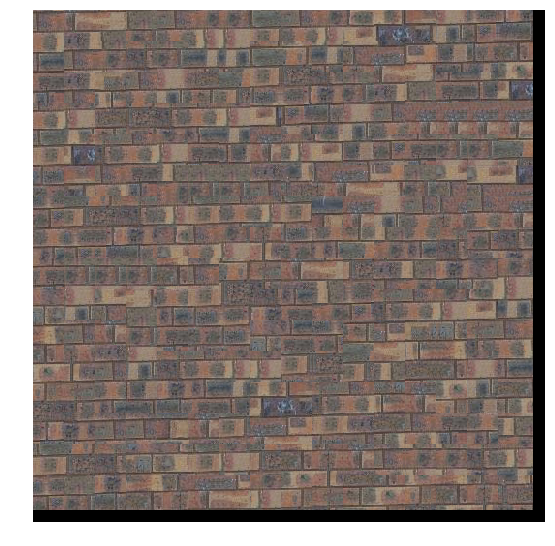

In [11]:
res = quilt_simple(sample_img, 512, 35, 4, 0.01) #feel free to change parameters to get best results
fig = plot_no_frame(res)
fig.savefig("results/overlapping.png")

# Part III: Seam Finding (20 pts)


In [12]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost, patch):
    ph, pw, _ = patch.shape
    n_row, n_col = bndcost.shape
    
    path_cost = np.zeros_like(bndcost)
    prev_ind = np.zeros_like(bndcost).astype(np.uint32)
    path_cost[:, 0] = bndcost[:, 0]
    for col in range(1, n_col):
        for row in range(n_row):
            start_row = row-1 if row > 1 else 0
            min_ind = np.argmin(path_cost[start_row:row+2, col-1])
            if row == 0:
                prev_ind[row, col] = min_ind
                path_cost[row, col] = path_cost[min_ind, col-1] + bndcost[row, col]
            else:
                prev_ind[row, col] = row + min_ind - 1
                path_cost[row, col] = path_cost[row+min_ind-1, col-1] + bndcost[row, col]
    
    mask_top = np.zeros((ph, pw), dtype=np.bool)
    mask_bot = np.zeros((ph, pw), dtype=np.bool)
    
    end_row = np.argmin(path_cost[:, -1])
    for col in range(n_col-1, -1, -1):
        mask_top[:end_row, col] = 1
        mask_bot[end_row:, col] = 1
        end_row = prev_ind[end_row, col]
        
    return mask_top, mask_bot

In [13]:
def find_seams(hw_ind, hw, sample, patch, out, overlap):

    ph, pw, c = patch.shape
    h_i, w_i = hw_ind
    h_start, w_start = hw

    mask_top = mask_left  = np.zeros((ph, pw), dtype=np.bool)
    mask_bot = mask_right = np.ones((ph, pw), dtype=np.bool)
    if w_i != 0:
        exist = out[h_start:h_start+ph, w_start:w_start+overlap]
        bndcost = np.sum((exist - patch[:, :overlap]) ** 2, axis=-1)

        mask_1, mask_2 = customized_cut(bndcost.T, np.transpose(patch, (1, 0, 2)))
        mask_left, mask_right = mask_1.T, mask_2.T
    if h_i != 0:
        exist = out[h_start:h_start+overlap, w_start:w_start+pw]
        bndcost = np.sum((exist - patch[:overlap, :]) ** 2, axis=-1)
        
        mask_top, mask_bot = customized_cut(bndcost, patch)
        
#         # Create demo images
#         hs = h_start + overlap - ph
#         bot_img = (mask_bot[:, :, np.newaxis].repeat(3, axis=-1) * patch).astype(np.uint8)
#         top_img = (mask_top[:, :, np.newaxis].repeat(3, axis=-1) * out[h_start:h_start+ph, w_start:w_start+pw]).astype(np.uint8)
#         top_img = np.concatenate((out[hs:hs+ph-overlap, w_start:w_start+pw, :],
#                                   top_img[:overlap, :, :]), axis=0).astype(np.uint8)
        
#         p1_fig  = plot_no_frame(out[hs:hs+ph, w_start:w_start+pw].astype(np.uint8))
#         p2_fig  = plot_no_frame(patch.astype(np.uint8))
#         top_fig = plot_no_frame(top_img)
#         bot_fig = plot_no_frame(bot_img)
#         ssd_fig = plot_no_frame(bndcost, cmap='gray')
        
#         p1_fig.savefig("results/top_patch.png")
#         p2_fig.savefig("results/bot_patch.png")
#         top_fig.savefig("results/top_masked.png")
#         bot_fig.savefig("results/bot_masked.png")
#         ssd_fig.savefig("results/ssd.png")
#         input("HERe")

    mask_out = np.logical_or(mask_top, mask_left)
    mask_new = np.logical_and(mask_bot, mask_right)
    mask_out = np.repeat(mask_out[:, :, np.newaxis], c, axis=-1)
    mask_new = np.repeat(mask_new[:, :, np.newaxis], c, axis=-1)

    patch = out[h_start:h_start+ph, w_start:w_start+pw, :] * mask_out + mask_new * patch
    return patch.astype(np.uint8)

In [14]:
def quilt_cut(sample, out_size, patch_size, overlap, tol,
              cor_sample=None, cor_target=None, alpha=0.5, prev_out=None):
    """
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    if isinstance(out_size, tuple):
        h_n_patch = int((out_size[0] - patch_size) / (patch_size - overlap) + 1)
        w_n_patch = int((out_size[1] - patch_size) / (patch_size - overlap) + 1)
        out = np.zeros(out_size, dtype=np.float32)
    else:
        c = sample.shape[2]
        out = np.zeros((out_size, out_size, c)).astype(np.float32)
        h_n_patch = w_n_patch = int((out_size - patch_size) / (patch_size - overlap) + 1)

    sample_gray = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY).astype(np.float32)
    mask, patch_gray = None, None
    
    for h_i in range(h_n_patch):
        for w_i in range(w_n_patch):

            h_start = patch_size * h_i - overlap * h_i
            h_end = h_start + patch_size
            w_start = patch_size * w_i - overlap * w_i
            w_end = w_start + patch_size

            cor_template = cor_target[h_start:h_end, w_start:w_end] if cor_target is not None else None
            if w_i == 0 and h_i == 0:
                k = 1
            else:
                k = 5
                mask = generate_mask(h_i, w_i, patch_size, overlap)
                patch_gray = cv2.cvtColor(out[h_start:h_end, w_start:w_end, :],
                                          cv2.COLOR_RGB2GRAY).astype(np.float32)
            
            ssd = ssd_patch(sample_gray, mask, patch_gray, overlap,
                            cor_sample=cor_sample, cor_template=cor_template, alpha=alpha)

            if prev_out is not None:
                prev_patch = prev_out[h_start:h_end, w_start:w_end]
                ssd_with_exist = ssd_patch(sample_gray, np.ones_like(prev_patch), prev_patch, overlap)
                ssd += ssd_with_exist

            patch, (hs, he), (ws, we) = choose_sample(ssd, (h_end-h_start, w_end-w_start), sample, k=k)
            
            if w_i != 0 or h_i != 0:
                patch = find_seams((h_i, w_i), (h_start, w_start), sample, patch, out, overlap)

            out[h_start:h_end, w_start:w_end, :] = patch

    return out.astype(np.uint8)

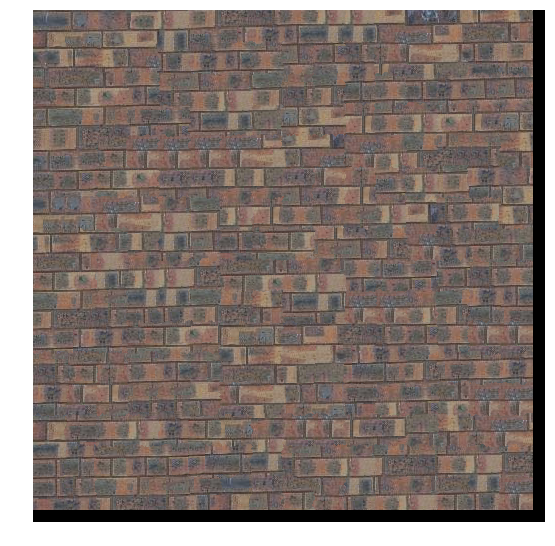

In [15]:
sample_img = cv2.imread("samples/bricks_small.jpg")
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
res = quilt_cut(sample_img, 512, 35, 4, 0.01)
fig = plot_no_frame(res)
fig.savefig("results/seam_finding.png")

In [16]:
def texture_transfer(sample, target, patch_size, overlap, alpha=0.5):
    lum_sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY).astype(np.float32)
    lum_target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY).astype(np.float32)

    sh, sw, sc = sample.shape
    th, tw, tc = target.shape
    
    return quilt_cut(sample, (th, tw, tc), patch_size, overlap, 0.01, cor_sample=lum_sample, cor_target=lum_target, alpha=alpha)

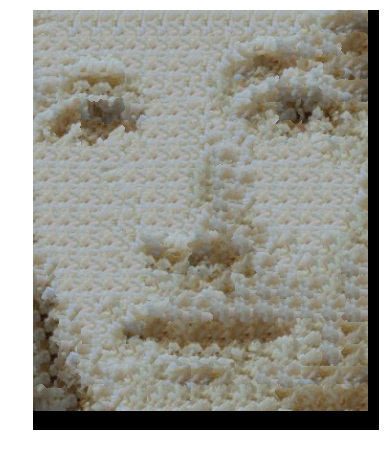

In [18]:
sample_path = 'samples/rice.png'
target_path = 'samples/face.png'

sample = cv2.imread(sample_path)
target = cv2.imread(target_path)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
quilt = texture_transfer(sample, target, 27, 5, alpha=0.1)
quilt = quilt.astype(np.uint8)

quilt_fig = plot_no_frame(quilt)
quilt_fig.savefig("results/rice_face.png")

# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(cv2.cvtColor(target, cv2.COLOR_RGB2GRAY), cmap='gray')
# axes[1].imshow(quilt)
# plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

In [19]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost, patch):
    ph, pw, _ = patch.shape
    n_row, n_col = bndcost.shape
    
    path_cost = np.zeros_like(bndcost)
    prev_ind = np.zeros_like(bndcost).astype(np.uint32)
    path_cost[:, 0] = bndcost[:, 0]
    for col in range(1, n_col):
        for row in range(n_row):
            start_row = row-1 if row > 1 else 0
            min_ind = np.argmin(path_cost[start_row:row+2, col-1])
            if row == 0:
                prev_ind[row, col] = min_ind
                path_cost[row, col] = path_cost[min_ind, col-1] + bndcost[row, col]
            else:
                prev_ind[row, col] = row + min_ind - 1
                path_cost[row, col] = path_cost[row+min_ind-1, col-1] + bndcost[row, col]
    
    mask_top = np.zeros((ph, pw), dtype=np.bool)
    mask_bot = np.zeros((ph, pw), dtype=np.bool)
    
    end_row = np.argmin(path_cost[:, -1])
    for col in range(n_col-1, -1, -1):
        mask_top[:end_row, col] = 1
        mask_bot[end_row:, col] = 1
        end_row = prev_ind[end_row, col]
        
    return mask_top, mask_bot

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

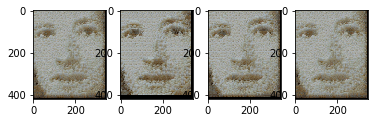

In [23]:
def texture_transfer_iter(sample, target, patch_size, overlap, N=3):
    lum_sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY).astype(np.float32)
    lum_target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY).astype(np.float32)

    sh, sw, sc = sample.shape
    th, tw, tc = target.shape
    
    out, outs = None, []
    for n in range(1, N+1):
        alpha = 0.8 * (n-1)/(N-1) + 0.1
        out = quilt_cut(sample, (th, tw, tc), patch_size, overlap, 0.01,
                        cor_sample=lum_sample, cor_target=lum_target, alpha=alpha, prev_out=out)
        
        outs.append(out)
        fig.savefig(f'results/water_fire_iter{n}.png')
        patch_size = int(patch_size * 2 / 3)
        if patch_size % 2 == 0:
            patch_size += 1
        
    return outs
        
sample_path = 'samples/rice.png'
target_path = 'samples/face.png'
# sample_path = 'samples/water.bmp'
# target_path = 'samples/fire.jpg'

sample = cv2.imread(sample_path)
target = cv2.imread(target_path)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
outs = texture_transfer_iter(sample, target, 27, 5)
res = outs[-1].astype(np.uint8)

fig, axes = plt.subplots(1, len(outs)+1)
axes[0].imshow(res)
for i, out in enumerate(outs):
    axes[i+1].imshow(out)
plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [24]:
def gaussian_kernel(sigma, kernel_half_size):
    '''
    Inputs:
        sigma = standard deviation for the gaussian kernel
        kernel_half_size = recommended to be at least 3*sigma
    
    Output:
        Returns a 2D Gaussian kernel matrix
    '''
    window_size = kernel_half_size*2+1
    gaussian_kernel_1d = signal.gaussian(window_size, std=sigma).reshape(window_size, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d) # make sure it sums to one

    return gaussian_kernel_2d

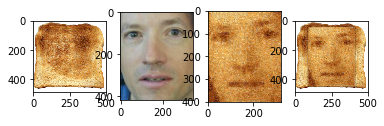

In [25]:
sample_path = 'samples/toast.jpg'
target_path = 'samples/face.png'
ksize = 15
padd = 0

sample = cv2.imread(sample_path)
target = cv2.imread(target_path)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
res = texture_transfer(sample, target, 27, 5)
res = res[:400, :320, :]

sh, sw, _ = sample.shape
th, tw, _ = res.shape
h_start = int((sh - th) / 2)
w_start = int((sw - tw) / 2)

mask = np.zeros((sh, sw), dtype=np.float32)
mask[h_start+padd:h_start+th-padd, w_start+padd:w_start+tw-padd] = 1

composite = np.zeros_like(sample, dtype=np.float32)

gauss = gaussian_kernel(5, 15)
mask = cv2.filter2D(mask, ddepth=-1, kernel=gauss)
mask = mask[:, :, np.newaxis].repeat(3, -1)
composite[h_start:h_start+th, w_start:w_start+tw] = res
new_img = mask * composite + (1 - mask) * sample.astype(np.float32)

fig, axes = plt.subplots(1, 4)
axes[0].imshow(sample)
axes[1].imshow(target)
axes[2].imshow(res.astype(np.uint8))
axes[3].imshow(new_img.astype(np.uint8))

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [26]:
def get_patch(img, h, w, half_h, half_w):
    if len(img.shape) == 2:
        hmax, wmax = img.shape
    else:
        hmax, wmax, _ = img.shape

    h_start = max(h - half_h, 0)
    h_end   = min(h + half_h + 1, hmax)
    w_start = max(w - half_w, 0)
    w_end   = min(w + half_w + 1, wmax)

    if len(img.shape) == 2:
        return img[h_start:h_end, w_start:w_end]
    else:
        return img[h_start:h_end, w_start:w_end, :]

In [27]:
def get_priority(conf_map, front_pts, cur_mask, cur_img, half_h, half_w, h, w):

    # Update confidence map
    new_conf_map = np.array(conf_map)
    for pts in front_pts:
        h_i, w_i = pts
        conf_patch = get_patch(conf_map, h_i, w_i, half_h, half_w)
        conf = conf_patch.sum() / conf_patch.size
        new_conf_map[h_i, w_i] = conf

    # Get data
    # Compute surface normal
    h_kernel = np.asarray([[-0.25, 0, 0.25], [-0.5, 0, 0.5], [-0.25, 0, 0.25]])
    v_kernel = np.asarray([[0.25, 0.5, 0.25], [-0.25, -0.5, -0.25], [0, 0, 0]])
    x_norm = scipy.signal.correlate2d(cur_mask, h_kernel, mode='same')
    y_norm = scipy.signal.correlate2d(cur_mask, v_kernel, mode='same')
    norm = np.dstack((x_norm, y_norm))

    delim = np.sqrt(x_norm ** 2 + y_norm ** 2)
    delim[delim == 0] = 1
    norm /= (delim[:, :, np.newaxis].repeat(2, axis=-1))

    # Compute gradient
    gray = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY).astype(np.float32)
    gray[cur_mask] = None

    gradients = np.array(np.gradient(gray))
    gradients = np.nan_to_num(gradients)
    gradients = np.rollaxis(gradients, 0, 3)
    grad_norm = np.sqrt(gradients[:, :, 0] ** 2 + gradients[:, :, 1] ** 2)
    max_grad = np.zeros_like(gradients)

    for pts in front_pts:
        h_i, w_i = pts
        norm_patch   = get_patch(grad_norm,          h_i, w_i, half_h, half_w)
        grad_x_patch = get_patch(gradients[:, :, 0], h_i, w_i, half_h, half_w)
        grad_y_patch = get_patch(gradients[:, :, 1], h_i, w_i, half_h, half_w)

        nh, nw = norm_patch.shape
        max_grad_pt = np.argmax(norm_patch)
        max_grad_h, max_grad_w = int(max_grad_pt / nw), max_grad_pt % nw

        max_grad[h_i, w_i, 0] = grad_x_patch[max_grad_h, max_grad_w]
        max_grad[h_i, w_i, 1] = grad_y_patch[max_grad_h, max_grad_w]

    data = norm * max_grad
    data = np.sqrt(data[:, :, 0] ** 2 + data[:, :, 1] ** 2) + 1e-6

    # Compute priority
    priority = new_conf_map * data * cur_mask
    return new_conf_map, priority

In [28]:
def inpaint(img, mask, patch_size):
    from skimage.filters import laplace

    img = img.astype(np.float32)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    h, w, c = img.shape
    half_h = half_w = int(patch_size/2)
    conf_map = (1 - mask).astype(np.float32)
    data = np.zeros((h, w), dtype=np.float32)

    cur_img = np.array(img).astype(np.float32)
    cur_img[mask] = 255
    cur_img_gray = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
    cur_mask = np.array(mask)

    total_painted = 0
    while cur_mask.sum() > 0:
        # Finding the front
        front_pts = np.argwhere(laplace(cur_mask) > 0)

        conf_map, priority = get_priority(conf_map, front_pts, cur_mask, cur_img, half_h, half_w, h, w)
        pt_to_patch = np.argmax(priority)
        h_to_patch, w_to_patch = int(pt_to_patch / w), pt_to_patch % w

        # Search for the most suitable patch
        mask_patch = get_patch(cur_mask,     h_to_patch, w_to_patch, half_h, half_w)
        img_patch  = get_patch(cur_img_gray, h_to_patch, w_to_patch, half_h, half_w)
        mh, mw = mask_patch.shape

        # ssd_patch(sample, mask, template, overlap)
        ssd = ssd_patch(img_gray, 1 - mask_patch, img_patch, 0)
        max_cost = np.max(ssd)
        valid = cv2.filter2D(1 - cur_mask, ddepth=-1, kernel=np.ones((mh, mw)))
        ssd[valid != mh * mw] = max_cost
        ssd[cur_mask] = max_cost

        # def choose_sample(ssd, patch_shape, sample, k=5)
        patch, (hs, he), (ws, we) = choose_sample(ssd, (mh, mw), cur_img, k=1)

        # Inpaint the area
        paste_hs = max(h_to_patch - half_h, 0)
        paste_he = min(h_to_patch + half_h + 1, h)
        paste_ws = max(w_to_patch - half_w, 0)
        paste_we = min(w_to_patch + half_w + 1, w)
        mask_patch_rgb = mask_patch[:, :, np.newaxis].repeat(3, axis=-1)
        cur_img[paste_hs:paste_he, paste_ws:paste_we] = \
                (1 - mask_patch_rgb) * cur_img[paste_hs:paste_he, paste_ws:paste_we] + \
                mask_patch_rgb       * cur_img[hs:he, ws:we]

        cur_img_gray = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)

        # Update conf_map using the confidence of the center point
        next_mask = np.array(cur_mask)
        next_mask[paste_hs:paste_he, paste_ws:paste_we] = 0
        new_pad = np.logical_and(next_mask == 0, cur_mask == 1)
        conf_map[new_pad] = conf_map[h_to_patch, w_to_patch]
        cur_mask = next_mask

        total_painted += new_pad.sum()
        print(f'Total painted: {total_painted}, Painted: {new_pad.sum()}, {cur_mask.sum()} more to paint')

    return cur_img.astype(np.uint8)

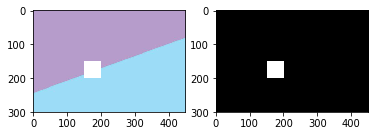

In [32]:
img = cv2.imread("samples/two_color.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2]).astype(np.bool)
mask[150:200, 150:200] = 1

img[mask] = 255
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[1].imshow(mask, cmap='gray')

Total painted: 225, Painted: 225, 2275 more to paint
Total painted: 450, Painted: 225, 2050 more to paint
Total painted: 675, Painted: 225, 1825 more to paint
Total painted: 975, Painted: 300, 1525 more to paint
Total painted: 1215, Painted: 240, 1285 more to paint
Total painted: 1425, Painted: 210, 1075 more to paint
Total painted: 1650, Painted: 225, 850 more to paint
Total painted: 1750, Painted: 100, 750 more to paint
Total painted: 1875, Painted: 125, 625 more to paint
Total painted: 2100, Painted: 225, 400 more to paint
Total painted: 2325, Painted: 225, 175 more to paint
Total painted: 2419, Painted: 94, 81 more to paint
Total painted: 2480, Painted: 61, 20 more to paint
Total painted: 2500, Painted: 20, 0 more to paint


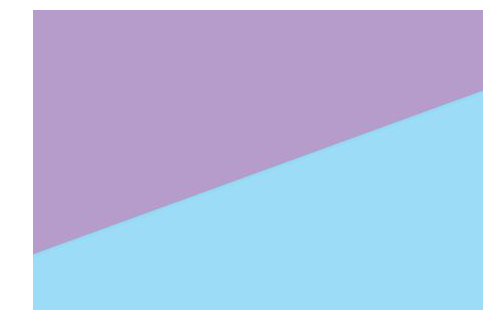

In [33]:
inpainted = inpaint(img, mask, patch_size=29)
inpainted_fig = plot_no_frame(inpainted)
inpainted_fig.savefig("results/two_color_inpainted.png")